In [2]:
# Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
# Warnings
import warnings
warnings.filterwarnings('ignore')
# Internal tool and helpers
import model_helpers as mh
import xgboost as xgb

In [3]:
data_path = "../CHESS/data/df_2_cod.csv"
df_2 = pd.read_csv(data_path)

In [4]:
# X e Y 
df = df_2.copy()
y_name = "winner_cod"
# X es el dataframe eliminando la variable de salida. Eliminando también 'moves' que ya está representado
X = df.drop(columns=[y_name, 'game_id', 'white_rating', 'black_rating', 'moves', 'current_turn_cod', 'opening_moves', 'rated_cod', 'current_turn_cod', 'time_increment_cod', 'opening_code_cod', 'opening_fullname_cod', 'opening_shortname_cod', 'opening_variation_cod', 'moves_fen_cod'])
# Y es un array unidimensional (ravel) de la variable de salida
Y = df[y_name].ravel()
X.columns

Index(['turns', 'ctrld_pawn', 'ctrld_knight', 'ctrld_bishop', 'ctrld_rook',
       'ctrld_queen', 'ctrld_king', 'preassure_points', 'controlled_diagonals',
       'controlled_lines'],
      dtype='object')

In [5]:
# división en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3)
X_train.columns

Index(['turns', 'ctrld_pawn', 'ctrld_knight', 'ctrld_bishop', 'ctrld_rook',
       'ctrld_queen', 'ctrld_king', 'preassure_points', 'controlled_diagonals',
       'controlled_lines'],
      dtype='object')

# XGboost

In [6]:
# Crear un clasificador XGBoost
xgboost = xgb.XGBClassifier()
# Entrenar el modelo en los datos de entrenamiento
xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [7]:
Yhat_xgboost_test = xgboost.predict(X_test)
Yhat_xgboost_train = xgboost.predict(X_train)
mh.eval_perform_class(Y_test,Yhat_xgboost_test, "Prueba", True)
mh.eval_perform_class(Y_train,Yhat_xgboost_train, "Entrenamiento", True)


Performance del modelo de Prueba
Accu 0.8396477234961781 
 Prec 0.8272047935464624 
 Reca 0.8396477234961781

Performance del modelo de Entrenamiento
Accu 0.9304843304843304 
 Prec 0.9298963651478747 
 Reca 0.9304843304843304


(0.9304843304843304, 0.9298963651478747, 0.9304843304843304)

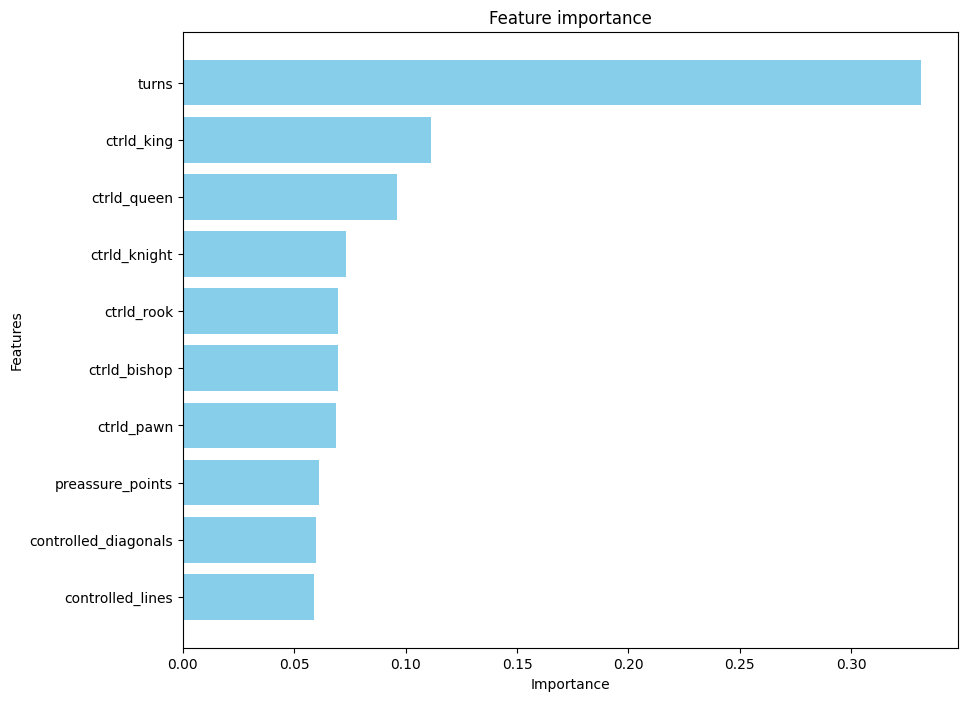

In [8]:
import matplotlib.pyplot as plt
# Feature importance
importance = xgboost.feature_importances_

df_importancia = pd.DataFrame({
    'Caracteristica': X.columns,
    'Importancia': importance
})

umbral = 0
# Filtrar los nombres de las características importantes
df_importancia = df_importancia[df_importancia['Importancia'] > umbral]
df_importancia = df_importancia.sort_values(by='Importancia', ascending=True)

features = df_importancia['Caracteristica']
importance = df_importancia['Importancia']


# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature importance')
plt.show()

In [14]:
import extract_features as ef
fen = 'rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2'
moves = 4
new_sample_df = ef.count_all_features(fen, moves)
new_sample_df

,turns,ctrld_pawn,ctrld_knight,ctrld_bishop,ctrld_rook,ctrld_queen,ctrld_king,preassure_points,controlled_diagonals,controlled_lines
0,4,14,5,5,0,4,1,9,2,0


In [15]:
# Human readable
ef.get_all_features(fen, moves).T

,0
turns,4
ctrld_pawn,"['h3', 'g3', 'f3', 'd3', 'c3', 'b3', 'a3', 'h4..."
ctrld_knight,"['Nh3', 'Nf3', 'Ne2', 'Nc3', 'Na3']"
ctrld_bishop,"['Ba6', 'Bb5', 'Bc4', 'Bd3', 'Be2']"
ctrld_rook,[]
ctrld_queen,"['Qh5', 'Qg4', 'Qf3', 'Qe2']"
ctrld_king,['Ke2']
preassure_points,"['e2', 'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3..."
controlled_diagonals,"({'c1': 0, 'f1': 1, 'd1': 1}, 'Total: 2')"
controlled_lines,"({'a1': 0, 'h1': 0, 'd1': 0}, 'Total: 0')"


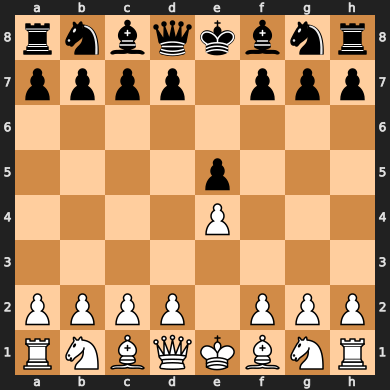

In [11]:
from chess import Board
# Mostrar el tablero de la primera cadena fen
board = Board(fen)
board

In [12]:
prob = xgboost.predict_proba(new_sample_df)
print(xgboost.classes_) # 0: negras. 1: empate. 2. blancas
print(f"Negras: {'{:.6f}'.format(prob[0][0])}. Empate:{'{:.6f}'.format(prob[0][1])}. Blancas:{'{:.6f}'.format(prob[0][2])}")


[0 1 2]
Negras: 0.491890. Empate:0.078860. Blancas:0.429250


In [13]:
import pickle
pickle.dump(xgboost, open("./pickles/models/xgoboost_model0407.pkl", 'wb'))